# Structural virality replication
Date: 1/27/2021

Author: Matthew Sun

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import datetime
from collections import defaultdict

import trecs
from trecs.models import BassModel
from trecs.random import SocialGraphGenerator

# custom utilities
from graph_utils import (
    calc_avg_degree, 
    implied_beta, 
    scale_free_graph, 
    setup_experiment,
    popularity,
    prob_large_cascade,
    mean_virality,
    std_virality,
    sem_virality,
    size_virality_corr,
    pearsonr_ci
)

from create_graphs import (
    destringify_r,
    destringify_alpha
)

# Load experimental results

In [6]:
f = open("sv_sims_10k_nodes.pkl", "rb")
results = pkl.load(f)
f.close()

In [7]:
def extract_alpha_rs(results_dict):
    """ Result the alpha and rs for the results dictionary.
    """
    alpha_set = set()
    r_set = set()
    for alpha, r in results_dict.keys():
        alpha_set.add(alpha)
        r_set.add(r)
    return sorted(list(alpha_set)), sorted(list(r_set))

In [8]:
alphas, rs = extract_alpha_rs(results)

In [9]:
# graphing
colors=['red', 'orange', 'green', 'blue', 'purple']

In [10]:
def plot_popularity_chance(results, alphas, rs):
    popularity_chance = {} # map from alpha to list, where each element corresponds to one R value
    for i, alpha in enumerate(alphas):
        popularity_chance[alpha] = [prob_large_cascade(results[(alpha, r)]["size"]) * 100 for r in rs]
        plt.plot(rs, popularity_chance[alpha], label=f"alpha={alpha}", color=colors[i])
    leg = plt.legend()
    plt.xlabel("r")
    plt.ylabel("Probability of popularity (%)")

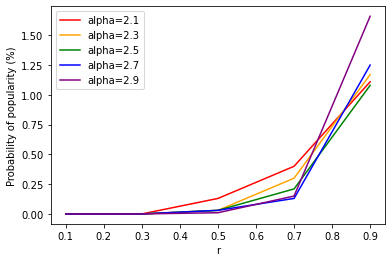

In [11]:
plot_popularity_chance(results, alphas, rs)

In [17]:
def plot_avg_virality(results, alphas, rs, pop_mask=False, sd_mult=0.0):
    avg_virality = defaultdict(list) # map from alpha to list, where each element corresponds to one R value
    sd_virality = defaultdict(list)
    for i, alpha in enumerate(alphas):
        for r in rs:
            mask = results[(alpha, r)]["size"] >= 100 if pop_mask else None            
            # restrict graph to popular cascades
            avg_virality[alpha].append(mean_virality(results[(alpha, r)]["virality"], popular_mask=mask))
            if sd_mult > 0:
                sd_virality[alpha].append(sem_virality(results[(alpha, r)]["virality"], popular_mask=mask))
        line = plt.plot(rs, avg_virality[alpha], label=f"alpha={alpha}", color=colors[i])
        line_color = line[0].get_color()
        if sd_mult > 0:
            low = np.array(avg_virality[alpha]) - np.array(sd_virality[alpha])
            high = np.array(avg_virality[alpha]) + np.array(sd_virality[alpha])
            plt.fill_between(rs, low, high, color = line_color, alpha=0.3)
    plt.legend()
    plt.xlabel("r")
    plt.ylabel("Mean structural virality")

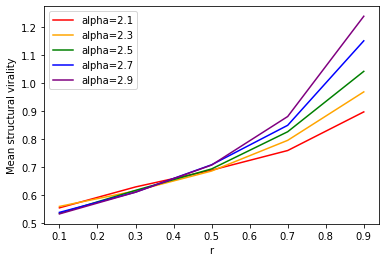

In [13]:
plot_avg_virality(results, alphas, rs)

In [14]:
def plot_size_vir_corr(results, alphas, rs, only_popular=False, with_ci=True):
    size_vir_corr = {} # map from alpha to list, where each element corresponds to one R value
    for i, alpha in enumerate(alphas):
        size_vir_corr[alpha] = []
        # bounds on correlation
        los = []
        highs = []
        for r in rs:
            print(f"alpha={alpha}, r={r}")
            corr = size_virality_corr(results[(alpha, r)]["size"], results[(alpha, r)]["virality"], only_popular=only_popular)
            size_vir_corr[alpha].append(corr)
            new_corr, _, lo, hi = pearsonr_ci(results[(alpha, r)]["size"], results[(alpha, r)]["virality"], only_popular=only_popular)
            los.append(corr - lo)
            highs.append(hi - corr)
        if with_ci:
            plt.errorbar(rs, size_vir_corr[alpha], yerr=np.vstack([los, highs]), label=f"alpha={alpha}",color=colors[i])
        else:
            plt.plot(rs, size_vir_corr[alpha], label=f"alpha={alpha}",color=colors[i])
        print()
    plt.legend()
    plt.xlabel("r")
    plt.ylabel("Correlation between size and structural virality")

alpha=2.1, r=0.1
Number of observations: 719
alpha=2.1, r=0.3
Number of observations: 1640
alpha=2.1, r=0.5
Number of observations: 2402
alpha=2.1, r=0.7
Number of observations: 3049
alpha=2.1, r=0.9
Number of observations: 3528

alpha=2.3, r=0.1
Number of observations: 792
alpha=2.3, r=0.3
Number of observations: 1911
alpha=2.3, r=0.5
Number of observations: 2697
alpha=2.3, r=0.7
Number of observations: 3506
alpha=2.3, r=0.9
Number of observations: 4107

alpha=2.5, r=0.1
Number of observations: 784
alpha=2.5, r=0.3
Number of observations: 2098
alpha=2.5, r=0.5
Number of observations: 3016
alpha=2.5, r=0.7
Number of observations: 3883
alpha=2.5, r=0.9
Number of observations: 4591

alpha=2.7, r=0.1
Number of observations: 883
alpha=2.7, r=0.3
Number of observations: 2172
alpha=2.7, r=0.5
Number of observations: 3329
alpha=2.7, r=0.7
Number of observations: 4125
alpha=2.7, r=0.9
Number of observations: 4861

alpha=2.9, r=0.1
Number of observations: 851
alpha=2.9, r=0.3
Number of observat

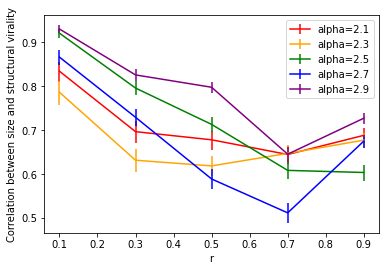

In [15]:
plot_size_vir_corr(results, alphas, rs)

In [16]:
def plot_popularity_ccdf(results, alphas, rs, only_popular=True):
    popularity_chance = {} # map from alpha to list, where each element corresponds to one R value
    for i, alpha in enumerate(alphas):
        for r in rs:
            sizes = results[(alpha, r)]["size"]
            if only_popular:
                sizes = sizes[sizes >= 100]
            plt.hist(sizes, bins=1000, density=True, histtype='step', cumulative=-1, label='Reversed emp.')
    leg = plt.legend()
    plt.xlabel("Cascade size")
    plt.ylabel("CCDF (%)")

### 1M node experiments

In [18]:
exp_dirs = ["graphs_1m_batch_sim", "graphs_1m_batch_100", "graphs_1m_batch_200k", "exps"]

agg_results = defaultdict(lambda: defaultdict(list)) # holds results for entire simulation
virality_multiplier = 2 # 2/25/2021: the structural virality measure in t-recs is 1/2 what it should be 

# process experimental results for each graph and add to aggregate results
for exp_dir in exp_dirs:
    for (root,dirs,files) in os.walk(exp_dir, topdown=True): 
        for f in files:
            if f == "sim_result.pkl":
                folders = os.path.normpath(root).split(os.path.sep)
                alpha, r = destringify_alpha(folders[-3]), destringify_r(folders[-2])
                result = pkl.load(open(os.path.join(root, f), "rb"))
                agg_results[(alpha, r)]["size"].append(result["size"])
                agg_results[(alpha, r)]["virality"].append(virality_multiplier * result["virality"])
            elif f == "merged_results.pkl":
                result = pkl.load(open(os.path.join(root, f), "rb"))
                for k in result.keys():
                    agg_results[k]["size"].append(result[k]["size"])
                    agg_results[k]["virality"].append(virality_multiplier * result[k]["virality"])
            
for alpha_r in agg_results.keys():
    agg_results[alpha_r]["size"] = np.concatenate(agg_results[alpha_r]["size"])
    agg_results[alpha_r]["virality"] = np.concatenate(agg_results[alpha_r]["virality"])

In [19]:
alphas, rs = extract_alpha_rs(agg_results)

In [20]:
# for each level of alpha and r, what are the #s of trials we observe?
for alpha in alphas:
    for r in rs:
        total_trials = agg_results[(alpha, r)]['size'].shape[0]
        print(f"Number of trials present for alpha={alpha}, r={r}: {total_trials}")
        num_large = len(np.where(agg_results[(alpha, r)]["size"] > 100)[0])
        print(f"Trials that resulted in large cascade: {num_large}")
        print()

Number of trials present for alpha=2.1, r=0.1: 55575
Trials that resulted in large cascade: 1

Number of trials present for alpha=2.1, r=0.3: 256400
Trials that resulted in large cascade: 41

Number of trials present for alpha=2.1, r=0.5: 39975
Trials that resulted in large cascade: 33

Number of trials present for alpha=2.1, r=0.7: 39875
Trials that resulted in large cascade: 76

Number of trials present for alpha=2.1, r=0.9: 18150
Trials that resulted in large cascade: 70

Number of trials present for alpha=2.3, r=0.1: 58700
Trials that resulted in large cascade: 0

Number of trials present for alpha=2.3, r=0.3: 270300
Trials that resulted in large cascade: 39

Number of trials present for alpha=2.3, r=0.5: 164800
Trials that resulted in large cascade: 114

Number of trials present for alpha=2.3, r=0.7: 39800
Trials that resulted in large cascade: 86

Number of trials present for alpha=2.3, r=0.9: 8550
Trials that resulted in large cascade: 70

Number of trials present for alpha=2.5,

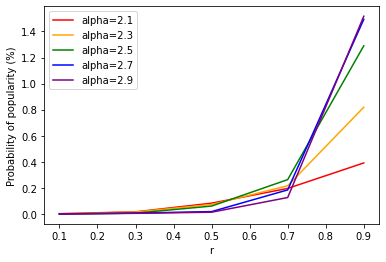

In [21]:
plot_popularity_chance(agg_results, alphas, rs)

In [22]:
# plot_avg_virality(agg_results, alphas, rs)

/home/mattsun/anaconda3/envs/trecs/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mattsun/anaconda3/envs/trecs/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/c/Users/matth/pton-research/recsys/experiments/structural_virality/graph_utils.py:96: RuntimeWarning: Mean of empty slice.
  return popular_viralitys[popular_viralitys > -1].mean()
/home/mattsun/anaconda3/envs/trecs/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mattsun/anaconda3/envs/trecs/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


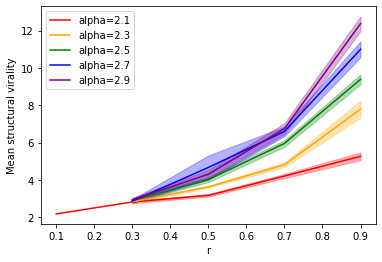

In [23]:
plot_avg_virality(agg_results, alphas, rs, pop_mask=True, sd_mult=1.0)

In [59]:
# plot_size_vir_corr(agg_results, alphas, rs)

alpha=2.1, r=0.5
Number of observations: 33
alpha=2.1, r=0.7
Number of observations: 78
alpha=2.1, r=0.9
Number of observations: 71

alpha=2.3, r=0.5
Number of observations: 119
alpha=2.3, r=0.7
Number of observations: 86
alpha=2.3, r=0.9
Number of observations: 70

alpha=2.5, r=0.5
Number of observations: 24
alpha=2.5, r=0.7
Number of observations: 70
alpha=2.5, r=0.9
Number of observations: 109

alpha=2.7, r=0.5
Number of observations: 7
alpha=2.7, r=0.7
Number of observations: 47
alpha=2.7, r=0.9
Number of observations: 112

alpha=2.9, r=0.5
Number of observations: 5
alpha=2.9, r=0.7
Number of observations: 32
alpha=2.9, r=0.9
Number of observations: 113



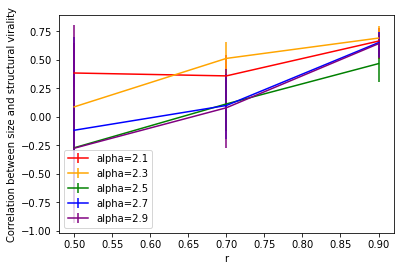

In [63]:
plot_size_vir_corr(agg_results, alphas, [0.5, 0.7, 0.9], only_popular=True)
# plt.ylim(0, 1.0)
# plt.xlim(0, 1.0)

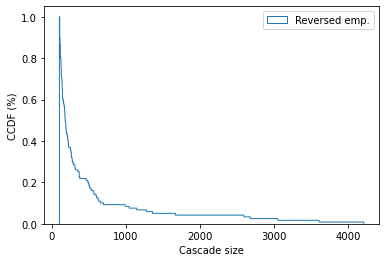

In [61]:
plot_popularity_ccdf(agg_results, [2.3], [0.5], only_popular=True)

In [67]:
# alpha = 2.3, r = 0.5 setting
size_virality_corr(agg_results[(2.3, 0.5)]["size"], agg_results[(2.3, 0.5)]["virality"], only_popular=True, pop_threshold=100)

Number of observations: 119


0.08558092125079826